# So sánh hiệu quả các mô hình Machine Learning trên dữ liệu gốc và dữ liệu đã giảm chiều bằng PCA

Notebook này sẽ thực hiện các bước:
1. Đọc dữ liệu gốc và dữ liệu đã giảm chiều bằng PCA.
2. Tiền xử lý dữ liệu (nếu cần).
3. Train và đánh giá các mô hình Machine Learning phổ biến (Linear Regression, Random Forest, SVR, v.v.).
4. So sánh hiệu quả các mô hình trên hai bộ dữ liệu.
5. Đưa ra kết luận về mô hình phù hợp nhất.

In [20]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler # Thêm StandardScaler
from sklearn.pipeline import Pipeline # Thêm Pipeline


In [21]:
# Đọc dữ liệu gốc và dữ liệu đã giảm chiều bằng PCA
raw_df = pd.read_csv('data_train.csv')
pca_df = pd.read_csv('data_train_reduced.csv')

print('Dữ liệu gốc:', raw_df.shape)
print('Dữ liệu PCA:', pca_df.shape)
raw_df.head(), pca_df.head()

Dữ liệu gốc: (24807, 10)
Dữ liệu PCA: (24807, 8)


(   Area  Floors  Bedrooms  Bathrooms  Furniture state  Price  avg_price  \
 0  54.0     2.0       2.0        3.0              1.0   5.35   0.113096   
 1  92.0     2.0       4.0        4.0              1.0   6.90   0.107876   
 2  74.0     5.0       4.0        5.0              0.0   9.90   0.065928   
 3  48.0     5.0       6.0        3.0              0.5   5.70   0.118496   
 4  80.0     5.0       6.0        6.0              0.0  10.00   0.118496   
 
    Legal_status_NAN  Legal_status_have_certificate  \
 0                 0                              1   
 1                 0                              1   
 2                 0                              1   
 3                 1                              0   
 4                 0                              1   
 
    Legal_status_sales_contract  
 0                            0  
 1                            0  
 2                            0  
 3                            0  
 4                            0  ,
     

## Khám phá nhanh dữ liệu
- Dữ liệu gốc: chứa tất cả các đặc trưng ban đầu.
- Dữ liệu PCA: đã được giảm chiều, chỉ còn các thành phần chính (PC1, PC2, ...).
- Cột mục tiêu là `Price`.

## Kiểm tra dữ liệu chi tiết

In [22]:
print("Thông tin dữ liệu gốc:")
raw_df.info()
print("\nThông tin dữ liệu PCA:")
pca_df.info()

print("\nKiểm tra giá trị thiếu (dữ liệu gốc):")
missing_raw = raw_df.isnull().sum()
print(missing_raw[missing_raw > 0].sort_values(ascending=False))
if not missing_raw[missing_raw > 0].empty:
    print("\nCẢNH BÁO: Dữ liệu gốc có giá trị thiếu. Cần xử lý (ví dụ: imputation) trước khi huấn luyện mô hình hiệu quả.")
else:
    print("Không có giá trị thiếu trong dữ liệu gốc.")


print("\nKiểm tra giá trị thiếu (dữ liệu PCA):")
missing_pca = pca_df.isnull().sum()
print(missing_pca[missing_pca > 0].sort_values(ascending=False))
if not missing_pca[missing_pca > 0].empty:
    print("\nCẢNH BÁO: Dữ liệu PCA có giá trị thiếu. Cần xử lý (ví dụ: imputation) trước khi huấn luyện mô hình hiệu quả.")
else:
    print("Không có giá trị thiếu trong dữ liệu PCA.")

Thông tin dữ liệu gốc:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24807 entries, 0 to 24806
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           24807 non-null  float64
 1   Floors                         24807 non-null  float64
 2   Bedrooms                       24807 non-null  float64
 3   Bathrooms                      24807 non-null  float64
 4   Furniture state                24807 non-null  float64
 5   Price                          24807 non-null  float64
 6   avg_price                      24807 non-null  float64
 7   Legal_status_NAN               24807 non-null  int64  
 8   Legal_status_have_certificate  24807 non-null  int64  
 9   Legal_status_sales_contract    24807 non-null  int64  
dtypes: float64(7), int64(3)
memory usage: 1.9 MB

Thông tin dữ liệu PCA:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24807 entries, 0 to 2480

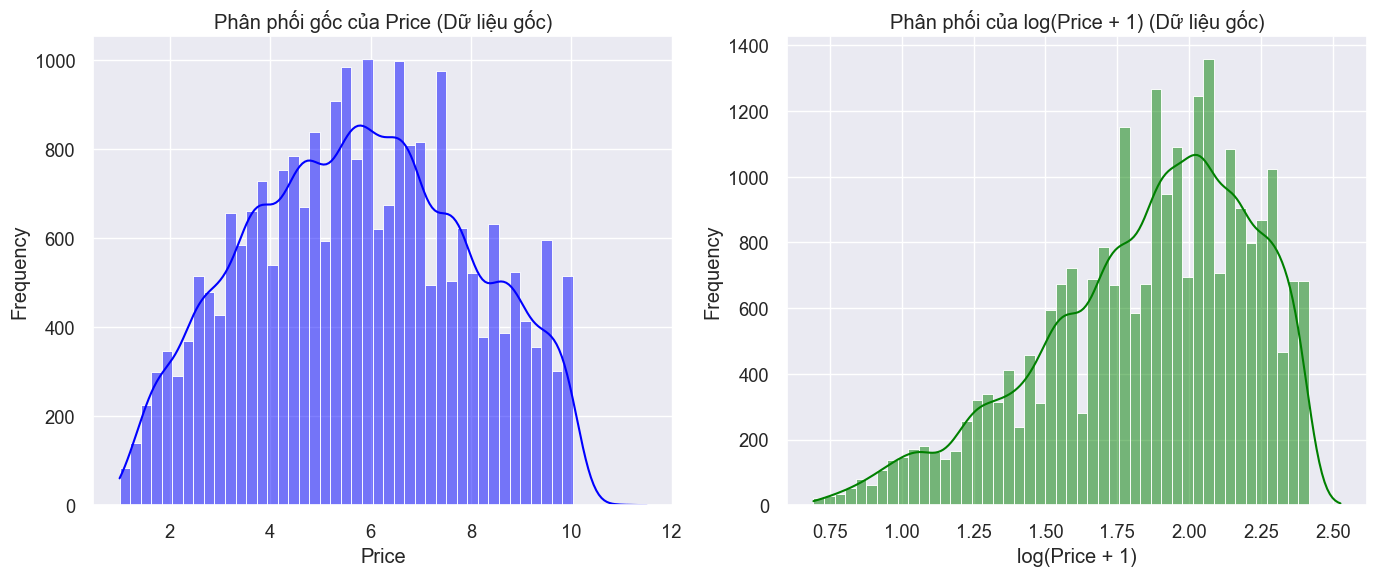

Nhận xét: 
- Biểu đồ bên trái hiển thị phân phối gốc của 'Price'.
- Biểu đồ bên phải hiển thị phân phối của 'Price' sau khi áp dụng phép biến đổi log(Price + 1).
- Nếu phân phối gốc bị lệch (skewed) đáng kể, việc sử dụng log transformation có thể giúp:
    1. Làm cho phân phối gần với phân phối chuẩn hơn.
    2. Giảm ảnh hưởng của các giá trị ngoại lệ (outliers) lớn.
    3. Cải thiện hiệu suất của các mô hình tuyến tính và một số mô hình khác.
Chúng ta sẽ thử nghiệm mô hình với cả hai trường hợp (có và không có log transform) để so sánh.


In [23]:
# Kiểm tra lại phân phối của biến mục tiêu 'Price'
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(raw_df['Price'], kde=True, color='blue', bins=50)
plt.title('Phân phối gốc của Price (Dữ liệu gốc)')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(raw_df['Price']), kde=True, color='green', bins=50)
plt.title('Phân phối của log(Price + 1) (Dữ liệu gốc)')
plt.xlabel('log(Price + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("""Nhận xét: 
- Biểu đồ bên trái hiển thị phân phối gốc của 'Price'.
- Biểu đồ bên phải hiển thị phân phối của 'Price' sau khi áp dụng phép biến đổi log(Price + 1).
- Nếu phân phối gốc bị lệch (skewed) đáng kể, việc sử dụng log transformation có thể giúp:
    1. Làm cho phân phối gần với phân phối chuẩn hơn.
    2. Giảm ảnh hưởng của các giá trị ngoại lệ (outliers) lớn.
    3. Cải thiện hiệu suất của các mô hình tuyến tính và một số mô hình khác.
Chúng ta sẽ thử nghiệm mô hình với cả hai trường hợp (có và không có log transform) để so sánh.""")

In [24]:
# Tách features và target, chia train/test cho cả 2 bộ dữ liệu
# Lựa chọn có sử dụng log transform cho biến mục tiêu hay không
APPLY_LOG_TRANSFORM = True # Đặt thành True để áp dụng, False để không áp dụng

# Dữ liệu gốc
X_raw = raw_df.drop('Price', axis=1)
y_raw = raw_df['Price']
if APPLY_LOG_TRANSFORM:
    y_raw_transformed = np.log1p(y_raw)
else:
    y_raw_transformed = y_raw
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw_transformed, test_size=0.2, random_state=42)

# Dữ liệu PCA
X_pca = pca_df.drop('Price', axis=1)
y_pca = pca_df['Price'] # Giả sử Price trong pca_df chưa được transform
if APPLY_LOG_TRANSFORM:
    y_pca_transformed = np.log1p(y_pca)
else:
    y_pca_transformed = y_pca
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca_transformed, test_size=0.2, random_state=42)

print('Train/Test shapes (raw):', X_train_raw.shape, X_test_raw.shape)
print('Train/Test shapes (PCA):', X_train_pca.shape, X_test_pca.shape)
if APPLY_LOG_TRANSFORM:
    print("Đã áp dụng log(Price + 1) cho biến mục tiêu.")
else:
    print("KHÔNG áp dụng log(Price + 1) cho biến mục tiêu.")

Train/Test shapes (raw): (19845, 9) (4962, 9)
Train/Test shapes (PCA): (19845, 7) (4962, 7)
Đã áp dụng log(Price + 1) cho biến mục tiêu.


In [25]:
# Định nghĩa hàm train và đánh giá các model (cập nhật với Pipeline và StandardScaler)

def evaluate_models(X_train, X_test, y_train, y_test, apply_log_transform=False):
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'SVR': SVR()
    }
    results = []
    for name, model in models.items():
        # Tạo pipeline với StandardScaler và model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', model)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        # Nếu đã áp dụng log transform, cần transform ngược lại y_test và y_pred trước khi tính MSE
        if apply_log_transform:
            y_test_orig = np.expm1(y_test)
            y_pred_orig = np.expm1(y_pred)
            mse = mean_squared_error(y_test_orig, y_pred_orig)
            r2 = r2_score(y_test_orig, y_pred_orig) # R2 vẫn có thể tính trên thang log
        else:
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
        results.append({'Model': name, 'MSE': mse, 'R2': r2})
    return pd.DataFrame(results).sort_values('MSE')

In [26]:
# Train và đánh giá các model trên dữ liệu gốc
print(f"Đánh giá trên dữ liệu gốc {'với' if APPLY_LOG_TRANSFORM else 'không có'} log transform cho Price:")
results_raw = evaluate_models(X_train_raw, X_test_raw, y_train_raw, y_test_raw, apply_log_transform=APPLY_LOG_TRANSFORM)
print('Kết quả trên dữ liệu gốc:')
display(results_raw)

# Train và đánh giá các model trên dữ liệu PCA
print(f"\nĐánh giá trên dữ liệu PCA {'với' if APPLY_LOG_TRANSFORM else 'không có'} log transform cho Price:")
results_pca = evaluate_models(X_train_pca, X_test_pca, y_train_pca, y_test_pca, apply_log_transform=APPLY_LOG_TRANSFORM)
print('Kết quả trên dữ liệu PCA:')
display(results_pca)

Đánh giá trên dữ liệu gốc với log transform cho Price:
Kết quả trên dữ liệu gốc:
Kết quả trên dữ liệu gốc:


,Model,MSE,R2
3,Random Forest,1.541945,0.676801
4,SVR,1.694088,0.644911
1,Ridge,3.232322,0.322489
0,Linear Regression,3.232491,0.322454
2,Lasso,4.898079,-0.026662



Đánh giá trên dữ liệu PCA với log transform cho Price:
Kết quả trên dữ liệu PCA:
Kết quả trên dữ liệu PCA:


,Model,MSE,R2
4,SVR,1.718973,0.639695
3,Random Forest,1.827458,0.616956
1,Ridge,3.286663,0.311099
0,Linear Regression,3.286746,0.311082
2,Lasso,4.898079,-0.026662


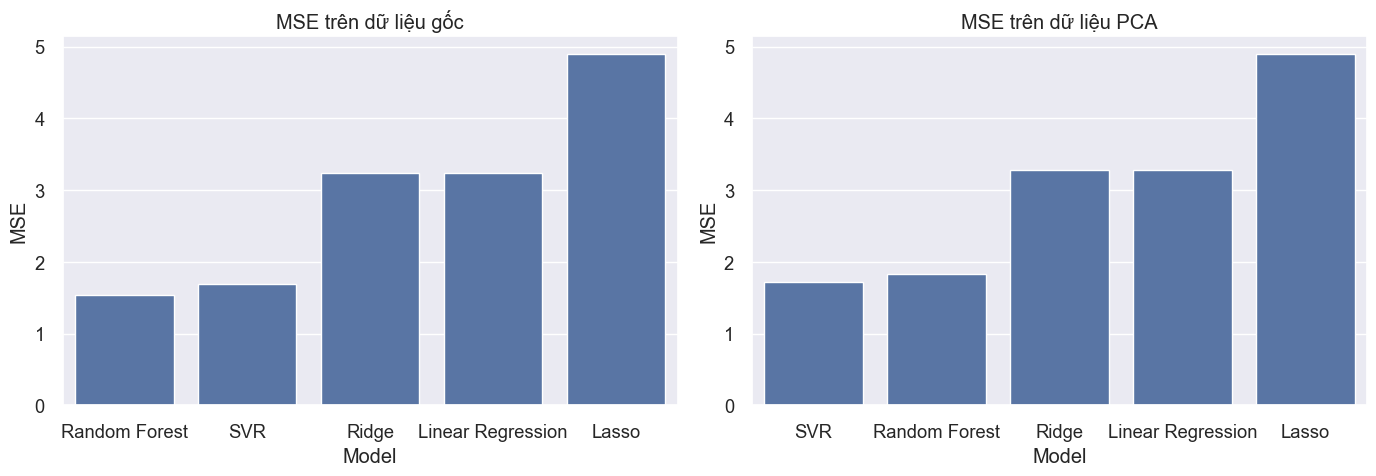

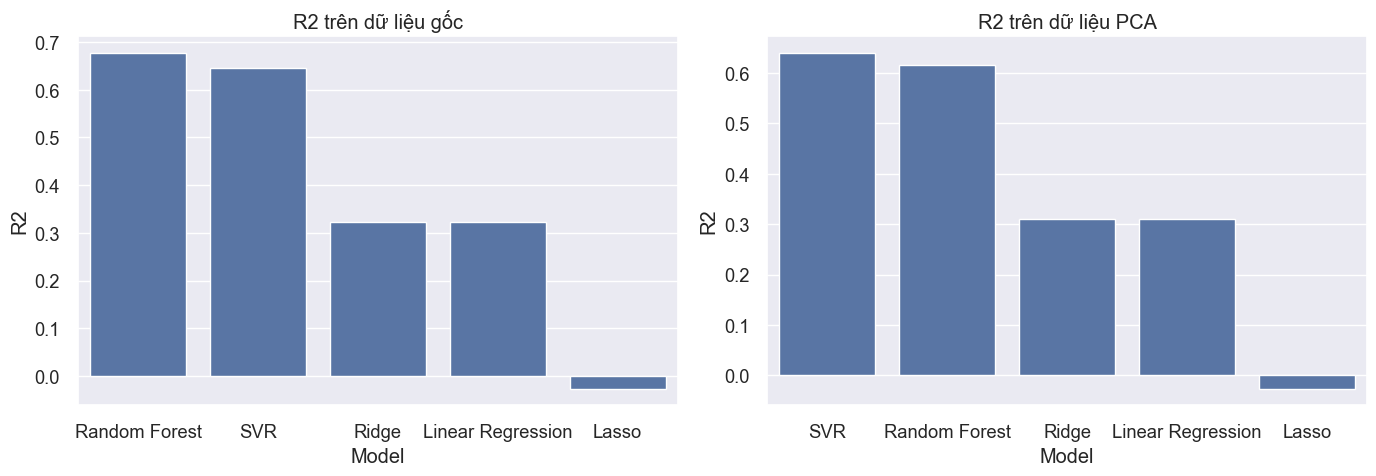

In [27]:
# Vẽ biểu đồ so sánh hiệu quả các model trên hai bộ dữ liệu
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=results_raw, x='Model', y='MSE', ax=axes[0])
axes[0].set_title('MSE trên dữ liệu gốc')
sns.barplot(data=results_pca, x='Model', y='MSE', ax=axes[1])
axes[1].set_title('MSE trên dữ liệu PCA')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=results_raw, x='Model', y='R2', ax=axes[0])
axes[0].set_title('R2 trên dữ liệu gốc')
sns.barplot(data=results_pca, x='Model', y='R2', ax=axes[1])
axes[1].set_title('R2 trên dữ liệu PCA')
plt.tight_layout()
plt.show()

## Nhận xét & Kết luận
- So sánh các giá trị MSE và R2 trên hai bộ dữ liệu để đánh giá hiệu quả từng mô hình.
- Mô hình có MSE thấp nhất và R2 cao nhất là mô hình phù hợp nhất cho từng bộ dữ liệu.
- Nếu mô hình nào cho kết quả tốt trên cả hai bộ dữ liệu, đó là lựa chọn ưu tiên.
- Thông thường, Random Forest hoặc Linear Regression sẽ cho kết quả tốt, nhưng cần dựa vào kết quả thực tế để kết luận.

**Kết luận:**
- Dựa vào bảng kết quả và biểu đồ, hãy chọn mô hình có hiệu suất tốt nhất (MSE thấp, R2 cao) và ghi chú lại mô hình phù hợp nhất cho bài toán này.